# Run Data Bias Analysis with SageMaker Clarify (Pre-Training)

## Using SageMaker Processing Jobs

In [1]:
import boto3
import sagemaker
import pandas as pd
import numpy as np

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


# Get Data from S3

In [2]:
%store -r bias_data_s3_uri

In [3]:
print(bias_data_s3_uri)

s3://sagemaker-us-east-1-992382405090/bias-detection-1721184321/amazon_reviews_us_giftcards_software_videogames.csv


In [4]:
!aws s3 cp $bias_data_s3_uri ./data-clarify

download: s3://sagemaker-us-east-1-992382405090/bias-detection-1721184321/amazon_reviews_us_giftcards_software_videogames.csv to data-clarify/amazon_reviews_us_giftcards_software_videogames.csv


In [5]:
import pandas as pd

data = pd.read_csv("./data-clarify/amazon_reviews_us_giftcards_software_videogames.csv")
data.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,24371595,R27ZP1F1CD0C3Y,B004LLIL5A,346014806,Amazon eGift Card - Celebrate,Gift Card,5,0,0,N,Y,Five Stars,Great birthday gift for a young adult.,2015-08-31
1,US,42489718,RJ7RSBCHUDNNE,B004LLIKVU,473048287,Amazon.com eGift Cards,Gift Card,5,0,0,N,Y,Gift card for the greatest selection of items ...,It's an Amazon gift card and with over 9823983...,2015-08-31
2,US,861463,R1HVYBSKLQJI5S,B00IX1I3G6,926539283,Amazon.com Gift Card Balance Reload,Gift Card,5,0,0,N,Y,Five Stars,Good,2015-08-31
3,US,25283295,R2HAXF0IIYQBIR,B00IX1I3G6,926539283,Amazon.com Gift Card Balance Reload,Gift Card,1,0,0,N,Y,One Star,Fair,2015-08-31
4,US,397970,RNYLPX611NB7Q,B005ESMGV4,379368939,"Amazon.com Gift Cards, Pack of 3 (Various Desi...",Gift Card,5,0,0,N,Y,Five Stars,I can't believe how quickly Amazon can get the...,2015-08-31


In [6]:
data.shape

(396601, 15)

### Data inspection
Plotting histograms for the distribution of the different features is a good way to visualize the data. 

<Axes: xlabel='star_rating', ylabel='count'>

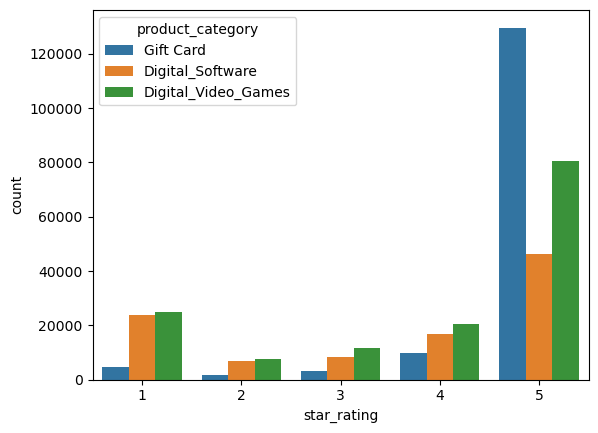

In [7]:
import seaborn as sns

sns.countplot(data=data, x="star_rating", hue="product_category")

# Detecting Bias with Amazon SageMaker Clarify

SageMaker Clarify helps you detect possible pre- and post-training biases using a variety of metrics.

In [8]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, 
    instance_count=1, 
    instance_type="ml.c5.xlarge", 
    sagemaker_session=sess
)

# Pre-training Bias
Bias can be present in your data before any model training occurs. Inspecting your data for bias before training begins can help detect any data collection gaps, inform your feature engineering, and hep you understand what societal biases the data may reflect.

Computing pre-training bias metrics does not require a trained model.

## Writing DataConfig
A `DataConfig` object communicates some basic information about data I/O to Clarify. We specify where to find the input dataset, where to store the output, the target column (`label`), the header names, and the dataset type.

In [9]:
bias_report_output_path = "s3://{}/clarify".format(bucket)

bias_data_config = clarify.DataConfig(
    s3_data_input_path=bias_data_s3_uri,
    s3_output_path=bias_report_output_path,
    label="star_rating",
    headers=data.columns.to_list(),
    dataset_type="text/csv",
)

## Writing BiasConfig
SageMaker Clarify also needs information on what the sensitive columns (`facets`) are, what the sensitive features (`facet_values_or_threshold`) may be, and what the desirable outcomes are (`label_values_or_threshold`).
Clarify can handle both categorical and continuous data for `facet_values_or_threshold` and for `label_values_or_threshold`. In this case we are using categorical data.

We specify this information in the `BiasConfig` API. Here that the positive outcome is `star rating==5`, `product_category` is the sensitive column, and `Gift Card` is the sensitive value.

In [10]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[5, 4],
    facet_name="product_category",
    facet_values_or_threshold=["Gift Card"],
)

## Detect Bias with a SageMaker Processing Job and Clarify

In [11]:
clarify_processor.run_pre_training_bias(
    data_config=bias_data_config, 
    data_bias_config=bias_config, 
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False, 
    logs=False
)

INFO:sagemaker:Creating processing-job with name Clarify-Pretraining-Bias-2024-07-17-05-56-22-983


In [12]:
run_pre_training_bias_processing_job_name = clarify_processor.latest_job.job_name
run_pre_training_bias_processing_job_name

'Clarify-Pretraining-Bias-2024-07-17-05-56-22-983'

In [15]:
from IPython.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">Processing Job</a></b>'.format(
            region, run_pre_training_bias_processing_job_name
        )
    )
)

In [16]:
from IPython.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format(
            region, run_pre_training_bias_processing_job_name
        )
    )
)

In [17]:
from IPython.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 Output Data</a> After The Processing Job Has Completed</b>'.format(
            bucket, run_pre_training_bias_processing_job_name, region
        )
    )
)

In [18]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=run_pre_training_bias_processing_job_name, sagemaker_session=sess
)

processing_job_description = running_processor.describe()

print(processing_job_description)

{'ProcessingInputs': [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-992382405090/bias-detection-1721184321/amazon_reviews_us_giftcards_software_videogames.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-992382405090/clarify/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}], 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'analysis_result', 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-992382405090/clarify', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}, 'AppManaged': False}]}, 'ProcessingJobName': 'Clarify-Pretraining-Bias-2024-07-17-05-56

In [19]:
running_processor.wait(logs=False)

.................................................!

# Download Report From S3
The class-imbalance metric should match the value calculated for the unbalanced dataset using the open source version above.

In [20]:
!aws s3 ls $bias_report_output_path/

2024-07-17 06:00:35       1960 analysis.json
2024-07-17 05:56:24        577 analysis_config.json
2024-07-17 06:00:35     544085 report.html
2024-07-17 06:00:35     271674 report.ipynb
2024-07-17 06:00:35     266791 report.pdf


In [21]:
!aws s3 cp --recursive $bias_report_output_path ./generated_bias_report/

download: s3://sagemaker-us-east-1-992382405090/clarify/analysis_config.json to generated_bias_report/analysis_config.json
download: s3://sagemaker-us-east-1-992382405090/clarify/analysis.json to generated_bias_report/analysis.json
download: s3://sagemaker-us-east-1-992382405090/clarify/report.ipynb to generated_bias_report/report.ipynb
download: s3://sagemaker-us-east-1-992382405090/clarify/report.pdf to generated_bias_report/report.pdf
download: s3://sagemaker-us-east-1-992382405090/clarify/report.html to generated_bias_report/report.html


In [23]:
from IPython.display import display, HTML

display(HTML('<b>Review <a target="blank" href="./generated_bias_report/report.html">Bias Report</a></b>'))

# Release Resources

In [25]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [24]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>